<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_Development_ZTM/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
#import helper script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-22 20:04:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-22 20:04:00 (73.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
# get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-10-22 20:04:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.13.240, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  85.0MB/s    in 1.9s    

2021-10-22 20:04:05 (85.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check out how mant images and subdirectories in the dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create and test directories path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size =  BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size =  BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# check out class names of the dataser
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
train_data_10_percent.snapshot

<bound method DatasetV2.snapshot of <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>>

In [11]:
# see an example of the batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 14.         10.          7.       ]
   [ 14.         10.          7.       ]
   [ 14.         10.          7.       ]
   ...
   [ 45.93878    22.938782   16.938782 ]
   [ 45.954075   22.954073   16.954073 ]
   [ 44.714287   21.714285   15.714286 ]]

  [[ 14.         10.          7.       ]
   [ 14.         10.          7.       ]
   [ 14.         10.          7.       ]
   ...
   [ 46.142834   23.142836   17.142836 ]
   [ 44.862247   21.862246   15.862246 ]
   [ 45.954082   22.954084   16.954084 ]]

  [[ 14.785714   10.          7.       ]
   [ 14.785714   10.          7.       ]
   [ 14.785714   10.          7.       ]
   ...
   [ 45.214264   22.214264   16.214264 ]
   [ 43.80102    20.801023   14.8010235]
   [ 45.86225    22.862253   16.862253 ]]

  ...

  [[248.5051    252.5051    253.5051   ]
   [249.9847    253.9847    254.9847   ]
   [251.04591   255.        254.83163  ]
   ...
   [240.04095   242.33183   237.33186  ]
   [245.19902   247.05614   246.12758  ]
   [2

In [12]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D{x.shape}")
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(None, 1280)


In [13]:
model_0.compile(loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [14]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name = "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211022-200412
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 86s 3s/step - loss: 1.9113 - accuracy: 0.3987 - val_loss: 1.3869 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 67s 3s/step - loss: 1.1554 - accuracy: 0.7453 - val_loss: 0.9761 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 79s 3s/step - loss: 0.8552 - accuracy: 0.8067 - val_loss: 0.7903 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 68s 3s/step - loss: 0.6946 - accuracy: 0.8360 - val_loss: 0.7037 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 78s 3s/step - loss: 0.5997 - accuracy: 0.8640 - val_loss: 0.6585 - val_accuracy: 0.8240


In [15]:
model_0.evaluate(test_data)

79/79 [==============================] - 123s 2s/step - loss: 0.6231 - accuracy: 0.8396


[0.6230993866920471, 0.8396000266075134]

In [16]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [17]:
#summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


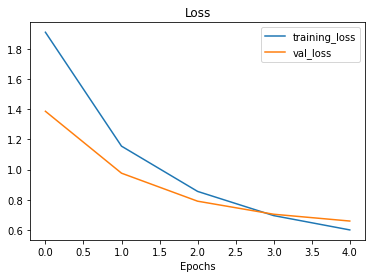

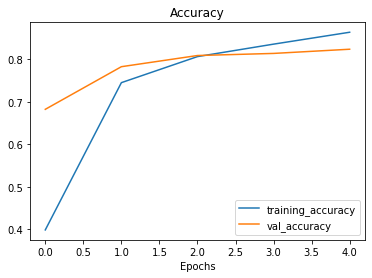

In [19]:
plot_loss_curves(history_10_percent)

In [29]:
## Getting a feature vector
# Demonstrate the Global Average pooling 2d layer
# Define input shape
input_shape = (1, 4, 4, 3)

#Create arandom tensor
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor} \n')

#pass random tensor through a global average pooling 2D layer
global_ave_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'global averaged pooled random tensor:\n {global_ave_tensor}')
print(f'Shape of  averaged pooled random tensor:\n {global_ave_tensor.shape}')

Random input tensor:
 [[[[-0.9221237  -0.2729726  -0.23237431]
   [ 0.47586983  0.03819659 -0.40616572]
   [ 0.56286126  1.3326315  -0.59911346]
   [ 1.0518057  -0.35220724  0.7206423 ]]

  [[-0.25427988 -1.2553849   0.8771749 ]
   [ 1.3570281  -1.264635    0.37263012]
   [ 1.4451404   0.31803438 -0.08671635]
   [ 0.5902739  -1.3310896   1.4204818 ]]

  [[-0.20915097 -1.07979     1.082943  ]
   [ 1.7010518   0.13804322 -1.9301804 ]
   [-0.2528812  -0.10354834  1.673265  ]
   [-1.4047419  -1.0235016  -0.21295841]]

  [[-0.6105121  -0.9844602  -0.6593094 ]
   [-0.54361725 -0.22588515 -0.6936333 ]
   [ 1.121584   -2.0749657  -2.030441  ]
   [ 0.03978997  0.39979008 -0.5855418 ]]]] 

global averaged pooled random tensor:
 [[ 0.25925618 -0.48385903 -0.08058107]]
Shape of  averaged pooled random tensor:
 (1, 3)


In [30]:
# replicate GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.25925618, -0.48385903, -0.08058107]], dtype=float32)>

##Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

 Why don't we answer that question while running the following modelling experiments:

1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.
While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetB0 model within the tf.keras.applications module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers.experimental.preprocessing module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [35]:
# Donwload andunzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2021-10-22 21:41:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.45.112, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.45.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   167MB/s    in 0.8s    

2021-10-22 21:41:28 (167 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [36]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [37]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [38]:
# Setup data loaders
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMAGE_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMAGE_SIZE,
                                                                           batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [58]:
# Add data augmentation layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping. rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      #preprocessing.Rescale(1./255) # keep for model like RasNet50V2
], name = "data_augmentation")

#Visualize data augmentation

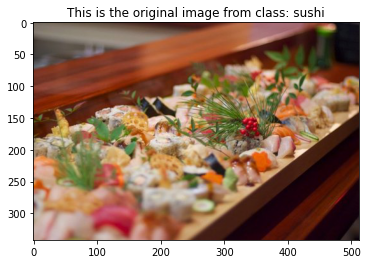

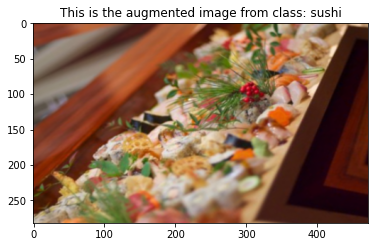

In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/"+ random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'This is the original image from class: {target_class}');

# Visualize augmnented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f'This is the augmented image from class: {target_class}');
plt.imshow(tf.squeeze(augmented_img)/255.)


## Model 1: Feature extraction learning on 1% percent of the data with augmentation


In [96]:
# setup the input shape and base, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape,
                      name = "input_layer")

# Add data augmentation as layer
x = data_augmentation(inputs)

# Give base models after inputs are augmented
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer as output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                #Track model training log
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211023-015252
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 54s 23s/step - loss: 2.2933 - accuracy: 0.1714 - val_loss: 2.1471 - val_accuracy: 0.2220
Epoch 2/5
3/3 [==============================] - 32s 15s/step - loss: 2.0386 - accuracy: 0.3286 - val_loss: 2.0273 - val_accuracy: 0.3059
Epoch 3/5
3/3 [==============================] - 45s 21s/step - loss: 1.8302 - accuracy: 0.4286 - val_loss: 1.9351 - val_accuracy: 0.3586


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f0f57fb2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f0f57fb2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 4/5
3/3 [==============================] - ETA: 0s - loss: 1.7139 - accuracy: 0.5571

KeyboardInterrupt: ignored

In [73]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [74]:
# Evaluate on the full test dataset
result_1_percent_dat_aug = model_1.evaluate(test_data)
result_1_percent_dat_aug

79/79 [==============================] - 122s 2s/step - loss: 1.7848 - accuracy: 0.4992


[1.7848237752914429, 0.4991999864578247]

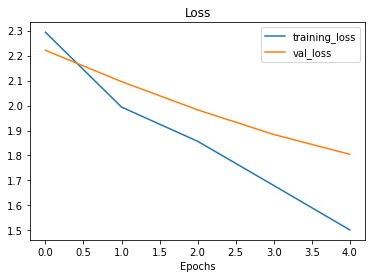

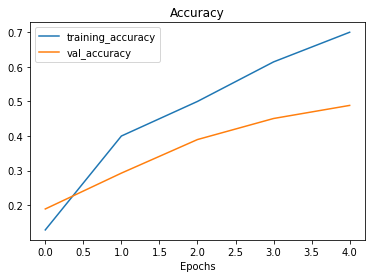

In [77]:
plot_loss_curves(history_1_percent)

In [97]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [98]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [99]:

# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [100]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [101]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [102]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211023-015703
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 76s 3s/step - loss: 2.0118 - accuracy: 0.3013 - val_loss: 1.4971 - val_accuracy: 0.6431

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 65s 3s/step - loss: 1.3652 - accuracy: 0.6747 - val_loss: 1.0669 - val_accuracy: 0.7484

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 80s 3s/step - loss: 1.0664 - accuracy: 0.7480 - val_loss: 0.8901 - val_accuracy: 0.7697

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 79s 3s/step - loss: 0.9173 - accuracy: 0.7627 - val_loss: 0.7636 - val_accuracy: 0.8043

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 80s 3s/step - loss: 0.7952 - accuracy: 0.8133 - val_loss: 0.7072 - 

In [106]:
model_0.evaluate(test_data)

79/79 [==============================] - 121s 2s/step - loss: 0.6231 - accuracy: 0.8396


[0.6230992078781128, 0.8396000266075134]

In [ ]:
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

68/79 [========================>.....] - ETA: 17s - loss: 0.6880 - accuracy: 0.8313

In [ ]:
plot_loss_curve(history_10_percent_data_aug)